# Hourly Energy Consumption Forecasting with XGBoost

## Business Problem
PJM Interconnection is a regional transmission organization that coordinates the movement of wholesale electricity in 13 states. They need accurate hourly load forecasts to:

- **Ensure grid stability** - Balance supply and demand in real-time
- **Optimize power purchasing** - Buy electricity at the best prices
- **Prevent blackouts** - Anticipate peak demand periods
- **Reduce energy waste** - Avoid over-generating electricity

**Impact**: Even a 1% improvement in forecast accuracy can save millions of dollars annually in operational costs.

## Project Goal
Build a production-ready forecasting model that predicts hourly energy consumption up to 1 year ahead, using historical patterns and temporal features.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()
print("✅ Libraries imported!")

✅ Libraries imported!


In [2]:
df = pd.read_csv('/kaggle/input/hourly-energy-consumption/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [3]:
print(df.shape)
print(df.head())
print(df.describe())

(145366, 1)
                     PJME_MW
Datetime                    
2002-12-31 01:00:00  26498.0
2002-12-31 02:00:00  25147.0
2002-12-31 03:00:00  24574.0
2002-12-31 04:00:00  24393.0
2002-12-31 05:00:00  24860.0
             PJME_MW
count  145366.000000
mean    32080.222831
std      6464.012166
min     14544.000000
25%     27573.000000
50%     31421.000000
75%     35650.000000
max     62009.000000


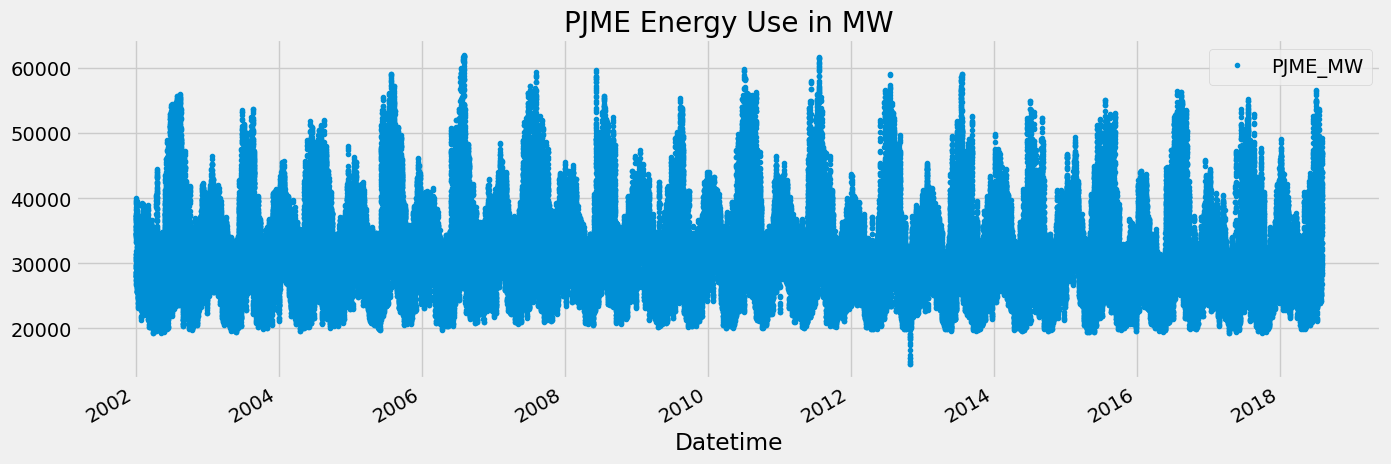

In [4]:
df.plot(style=".",
        figsize=(15,5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

In [5]:
df.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

# **Step 1: Outlier Analysis and Removal**

In [6]:
#Remove outliers using IQR method
# These represent extreme values that could confuse the model
# The IQR method removes points that are too far from the normal range

Q1 = df['PJME_MW'].quantile(0.25)
Q3 = df['PJME_MW'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")

Lower bound: 15457.5
Upper bound: 47765.5


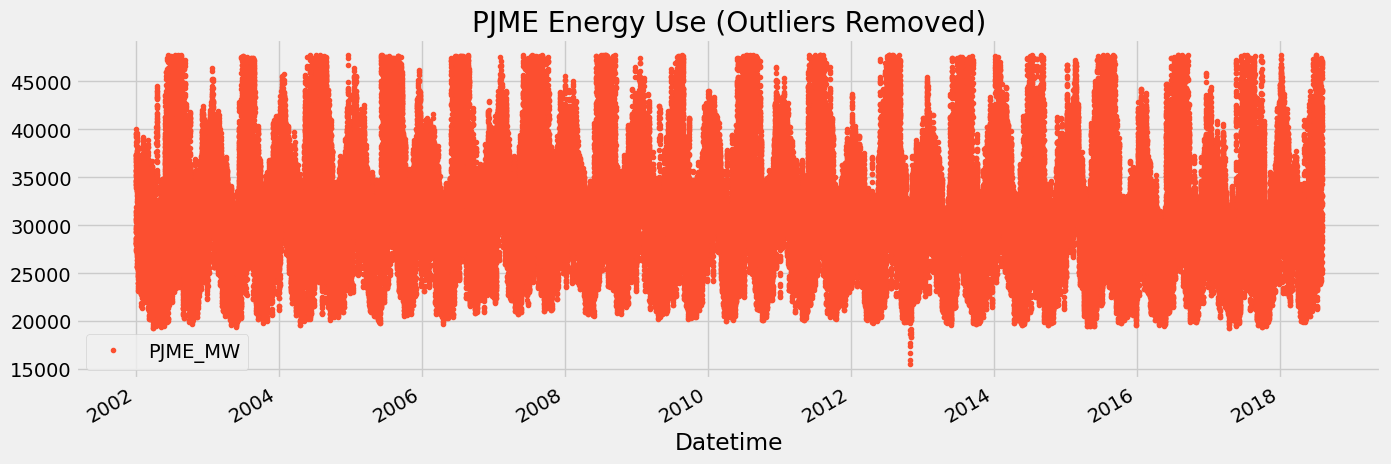

In [7]:
#Filter out outliers - keeping only normal values
df = df[(df['PJME_MW'] >= lower_bound) & (df['PJME_MW'] <= upper_bound)]

#Plot after removing outliers
df.plot(style=".",
        figsize=(15,5),
        color=color_pal[1],
        title='PJME Energy Use (Outliers Removed)')
plt.show()

# **Step 2: Train / Test Split**

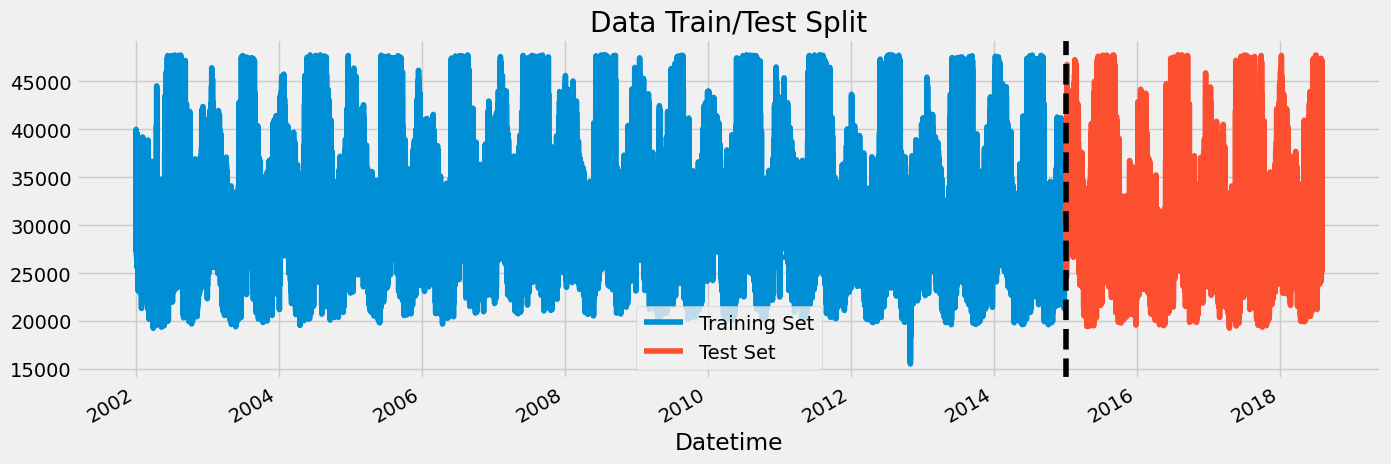

In [8]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# **Step 3: Feature Creation**

In [9]:
# Create time series features
def create_features(df):
    """
    Create time series features based on time series index.
    These features help the model capture:
    - Daily patterns (hour)
    - Weekly patterns (dayofweek)
    - Seasonal patterns (month, quarter)
    - Long-term trends (year)
    
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

# Apply to train and test
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

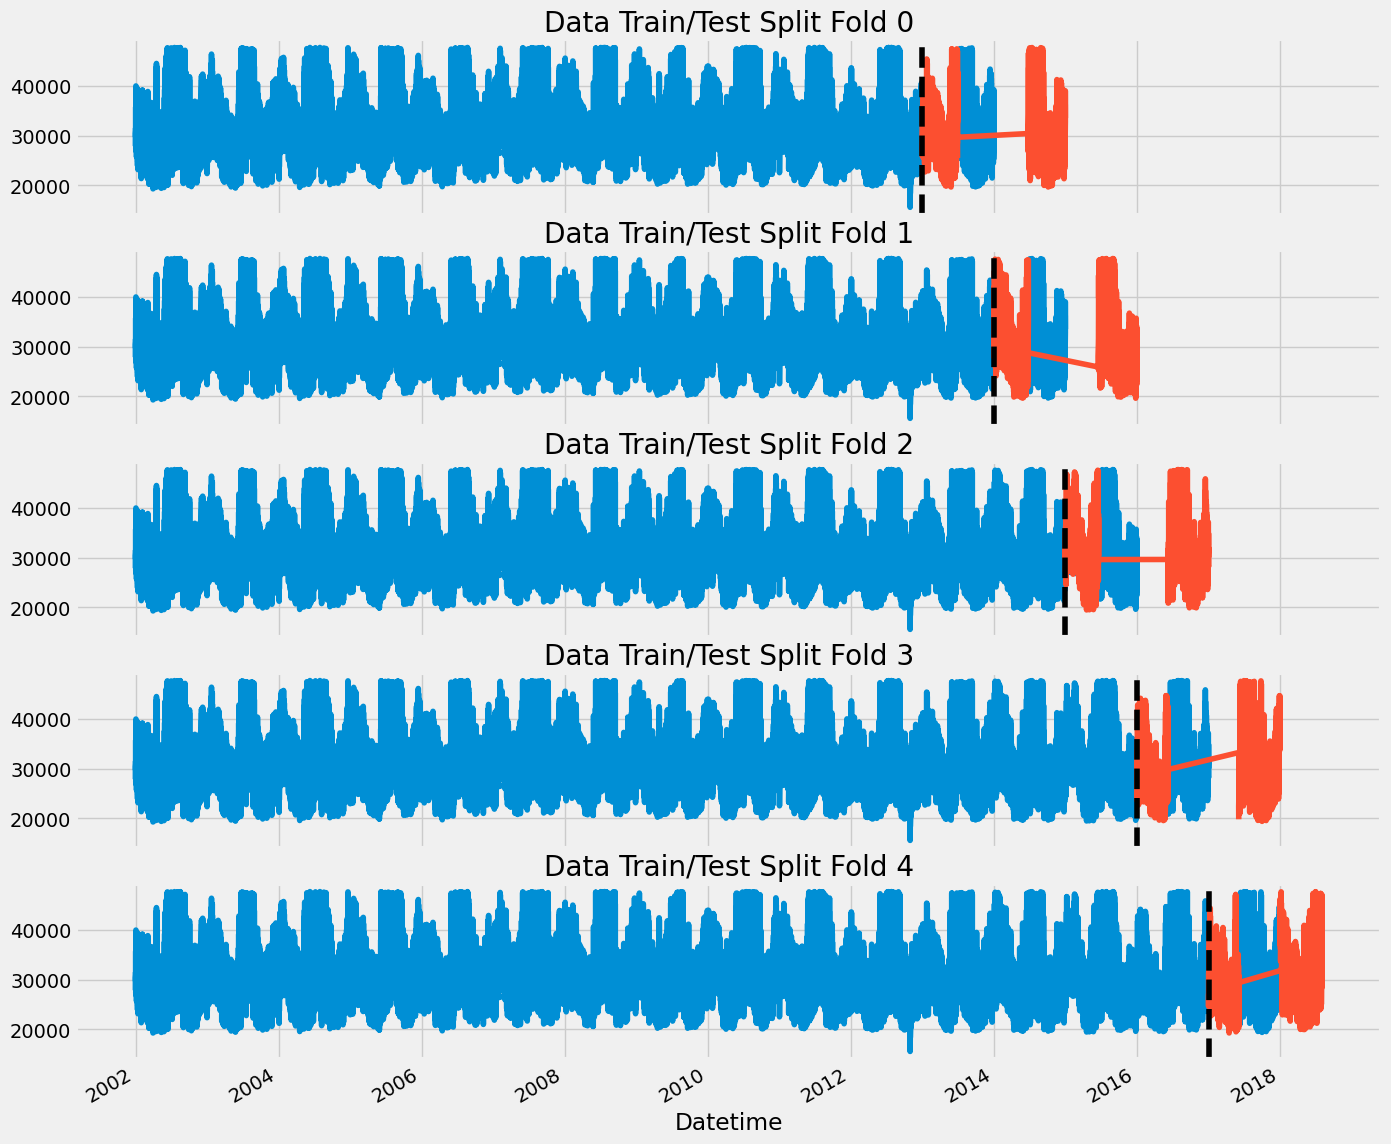

In [10]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# **Forecasting Horizon**

In [11]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# **Lag Features**
* What was the target (x) days in the past.

In [12]:
def add_lags(df):
    """
    Create lag features to capture yearly seasonality.
    - lag1: value from 364 days ago (approx 1 year)
    - lag2: value from 728 days ago (approx 2 years)
    - lag3: value from 1092 days ago (approx 3 years)
    
    Energy consumption patterns repeat yearly due to seasons,
    so past years' values are strong predictors.
    
    """
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [13]:
df = add_lags(df)

# **Train using Cross Validation**

[0]	validation_0-rmse:32043.63543	validation_1-rmse:31928.18633


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [16:33:05] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12194.49013	validation_1-rmse:12251.51762
[200]	validation_0-rmse:5425.16758	validation_1-rmse:5606.12930
[300]	validation_0-rmse:3521.01887	validation_1-rmse:3809.66114
[400]	validation_0-rmse:3076.72847	validation_1-rmse:3475.62688
[500]	validation_0-rmse:2958.88511	validation_1-rmse:3438.77172
[584]	validation_0-rmse:2911.12167	validation_1-rmse:3440.50324
[0]	validation_0-rmse:32033.01113	validation_1-rmse:31788.69795


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [16:33:12] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12192.82985	validation_1-rmse:12154.87061
[200]	validation_0-rmse:5436.37024	validation_1-rmse:5535.04157
[300]	validation_0-rmse:3545.89851	validation_1-rmse:3743.39300
[400]	validation_0-rmse:3120.39965	validation_1-rmse:3386.73525
[500]	validation_0-rmse:3006.15769	validation_1-rmse:3318.78337
[600]	validation_0-rmse:2952.52877	validation_1-rmse:3287.80366
[700]	validation_0-rmse:2916.52722	validation_1-rmse:3259.20129
[800]	validation_0-rmse:2884.89167	validation_1-rmse:3220.44203
[900]	validation_0-rmse:2858.96437	validation_1-rmse:3201.40996
[999]	validation_0-rmse:2837.43872	validation_1-rmse:3191.88417
[0]	validation_0-rmse:32015.59760	validation_1-rmse:30613.03185


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [16:33:22] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12188.71170	validation_1-rmse:11034.36835
[200]	validation_0-rmse:5443.94422	validation_1-rmse:4662.23715
[300]	validation_0-rmse:3569.34091	validation_1-rmse:3316.25050
[400]	validation_0-rmse:3149.31463	validation_1-rmse:3257.11797
[406]	validation_0-rmse:3138.12711	validation_1-rmse:3260.04971
[0]	validation_0-rmse:31919.15403	validation_1-rmse:31064.77068


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [16:33:27] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12157.88034	validation_1-rmse:11977.86402
[200]	validation_0-rmse:5437.40542	validation_1-rmse:5651.29345
[300]	validation_0-rmse:3568.86824	validation_1-rmse:4093.68465
[400]	validation_0-rmse:3164.93094	validation_1-rmse:3883.30795
[500]	validation_0-rmse:3053.41076	validation_1-rmse:3715.37825
[600]	validation_0-rmse:2995.29734	validation_1-rmse:3687.97269
[700]	validation_0-rmse:2956.01308	validation_1-rmse:3682.12413
[800]	validation_0-rmse:2924.26367	validation_1-rmse:3676.91145
[900]	validation_0-rmse:2899.75093	validation_1-rmse:3670.05536
[967]	validation_0-rmse:2885.69918	validation_1-rmse:3670.71290
[0]	validation_0-rmse:31864.28889	validation_1-rmse:31221.68529


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [16:33:37] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12146.95799	validation_1-rmse:12055.56107
[200]	validation_0-rmse:5452.48906	validation_1-rmse:5640.30697
[300]	validation_0-rmse:3603.70077	validation_1-rmse:4032.30071
[400]	validation_0-rmse:3197.14777	validation_1-rmse:3773.54833
[500]	validation_0-rmse:3089.24050	validation_1-rmse:3750.32704
[565]	validation_0-rmse:3053.97419	validation_1-rmse:3751.68991


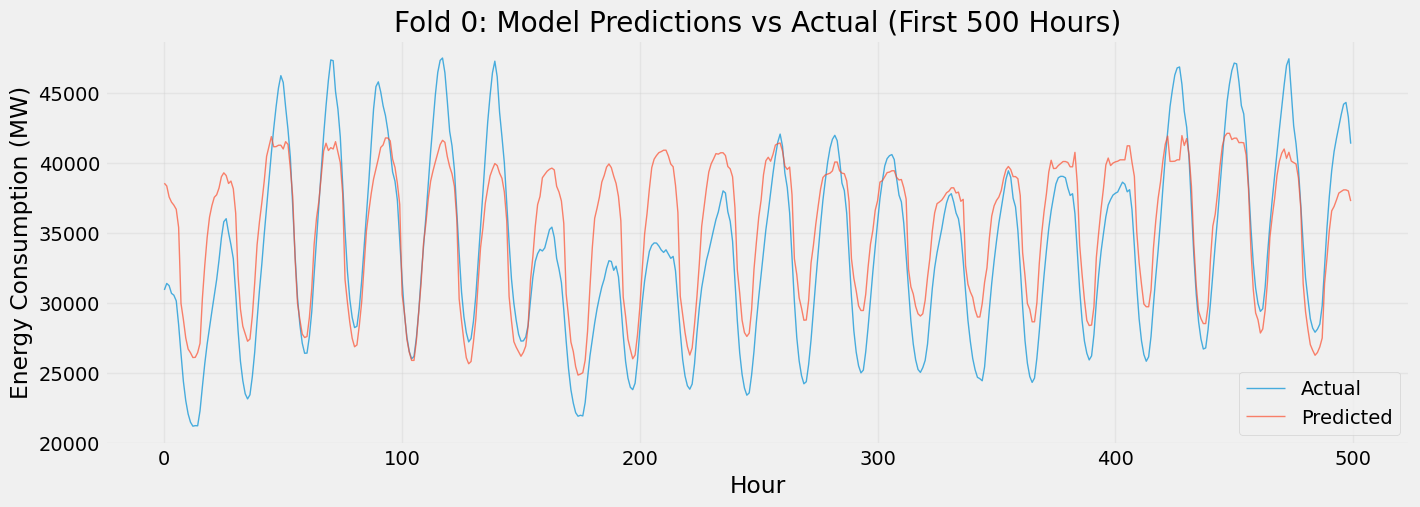

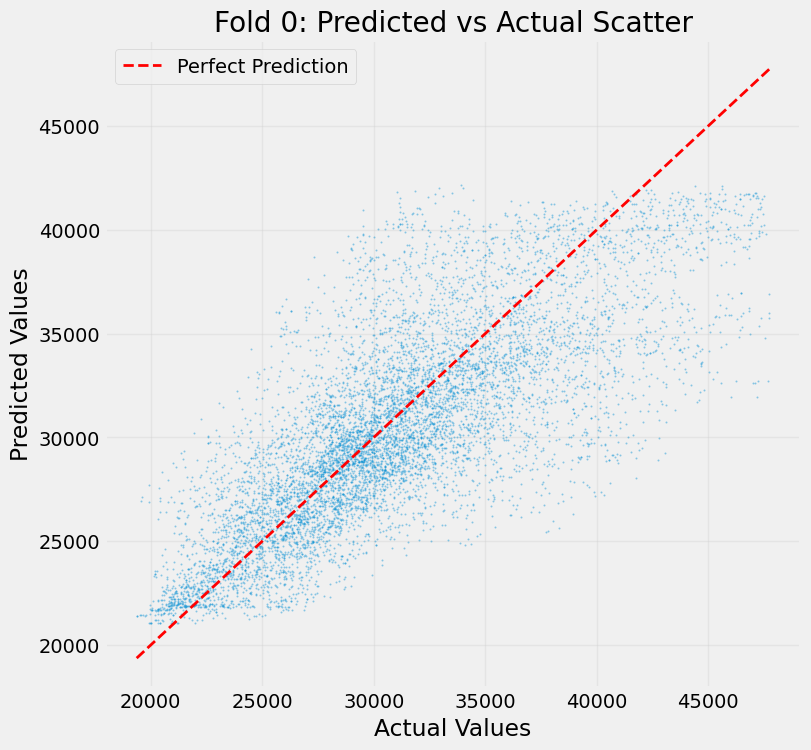

In [14]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)

    # Visualize predictions vs actual for first fold only
if fold == 0:
    plt.figure(figsize=(15, 5))
    plt.plot(y_test.values[:500], label='Actual', alpha=0.7, linewidth=1)
    plt.plot(y_pred[:500], label='Predicted', alpha=0.7, linewidth=1)
    plt.title(f'Fold {fold}: Model Predictions vs Actual (First 500 Hours)')
    plt.xlabel('Hour')
    plt.ylabel('Energy Consumption (MW)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Also show a scatter plot
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test.values, y_pred, alpha=0.3, s=1)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Fold {fold}: Predicted vs Actual Scatter')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

In [15]:
# Calculate and display model performance
avg_rmse = np.mean(scores)
print(f'XGBoost RMSE across folds: {avg_rmse:0.0f} MW')
print(f'Individual fold scores: {[int(s) for s in scores]}')

# Calculate simple baseline for comparison
# Baseline: predict same hour from last week
print("\n--- Comparing to Simple Baseline ---")
df_baseline = df.copy()
df_baseline['baseline'] = df_baseline['PJME_MW'].shift(24*7)  # 7 days * 24 hours

# Remove NaN values from shifting
baseline_comparison = df_baseline.dropna()
baseline_rmse = np.sqrt(mean_squared_error(
    baseline_comparison['PJME_MW'], 
    baseline_comparison['baseline']
))

# Calculate improvement
improvement = ((baseline_rmse - avg_rmse) / baseline_rmse) * 100

print(f"Simple Baseline RMSE (predict last week): {baseline_rmse:.0f} MW")
print(f"XGBoost RMSE: {avg_rmse:.0f} MW")
print(f"Improvement: {improvement:.1f}% better than baseline")

# Calculate RMSE as percentage of average load
avg_load = df['PJME_MW'].mean()
rmse_percentage = (avg_rmse / avg_load) * 100
print(f"\nAverage hourly load: {avg_load:.0f} MW")
print(f"RMSE as % of average load: {rmse_percentage:.1f}%")

# Calculate accuracy percentage
accuracy_percentage = 100 - rmse_percentage
print(f"\nModel Accuracy: {accuracy_percentage:.1f}%")
print(f"   (This means predictions are within {rmse_percentage:.1f}% of actual values on average)")

# Simple interpretation
if accuracy_percentage > 90:
    print("Excellent accuracy. Model is performing very well.")
elif accuracy_percentage > 85:
    print("Good accuracy: model is solid.")
else:
    print("Acceptable accuracy: could be improved with more features.")

XGBoost RMSE across folds: 3748 MW
Individual fold scores: [3747]

--- Comparing to Simple Baseline ---
Simple Baseline RMSE (predict last week): 4890 MW
XGBoost RMSE: 3748 MW
Improvement: 23.4% better than baseline

Average hourly load: 31616 MW
RMSE as % of average load: 11.9%

Model Accuracy: 88.1%
   (This means predictions are within 11.9% of actual values on average)
Good accuracy: model is solid.


# **Predicting the Future**

In [16]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:31824.83976


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [16:33:45] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12136.04348
[200]	validation_0-rmse:5462.76522
[300]	validation_0-rmse:3634.73839
[400]	validation_0-rmse:3234.01373
[499]	validation_0-rmse:3130.04969


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [17]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [18]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)

In [19]:
# Get future data
future_w_features = df_and_future.query('isFuture').copy()

In [20]:
# Retrain model WITHOUT lag features for future prediction
FEATURES_NO_LAGS = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
X_all_no_lags = df[FEATURES_NO_LAGS]
y_all = df[TARGET]

reg_future = xgb.XGBRegressor(base_score=0.5,
                              booster='gbtree',    
                              n_estimators=500,
                              objective='reg:linear',
                              max_depth=3,
                              learning_rate=0.01)
reg_future.fit(X_all_no_lags, y_all,
               eval_set=[(X_all_no_lags, y_all)],
               verbose=100)

[0]	validation_0-rmse:31826.16764


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [16:33:51] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12237.04997
[200]	validation_0-rmse:5610.34213
[300]	validation_0-rmse:3747.85327
[400]	validation_0-rmse:3287.99844
[499]	validation_0-rmse:3131.97037


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

FEATURE IMPORTANCE ANALYSIS

Top 5 Most Important Features:
  month: 0.312 (31.2%)
  hour: 0.286 (28.6%)
  dayofweek: 0.182 (18.2%)
  dayofyear: 0.126 (12.6%)
  quarter: 0.067 (6.7%)

All Features by Importance:
  feature  importance
    month    0.312090
     hour    0.286156
dayofweek    0.181545
dayofyear    0.126061
  quarter    0.066785
     year    0.027363


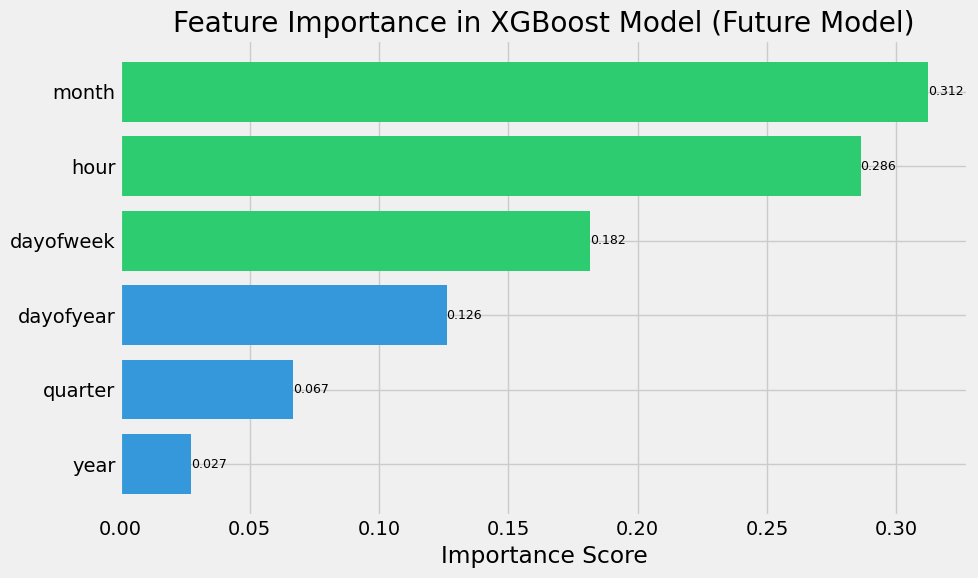

INTERPRETATION
For the future forecasting model (without lag features),
the most important features are time-based patterns:
- Month captures seasonal energy demand (heating/cooling)
- Hour captures daily consumption cycles (peak/off-peak)
- Day of week distinguishes weekends from weekdays

Since we can't use lag features for future prediction,
these temporal features become even more critical.


In [21]:
# Analyze feature importance for the future model
feature_importance = pd.DataFrame({
    'feature': FEATURES_NO_LAGS,
    'importance': reg_future.feature_importances_
}).sort_values('importance', ascending=False)

print("FEATURE IMPORTANCE ANALYSIS")
print("\nTop 5 Most Important Features:")
for i, row in feature_importance.head(5).iterrows():
    print(f"  {row['feature']}: {row['importance']:.3f} ({row['importance']*100:.1f}%)")

print("\nAll Features by Importance:")
print(feature_importance.to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 6))
colors = ['#2ecc71' if i < 3 else '#3498db' for i in range(len(feature_importance))]
bars = plt.barh(feature_importance['feature'], feature_importance['importance'], color=colors)
plt.xlabel('Importance Score')
plt.title('Feature Importance in XGBoost Model (Future Model)')
plt.gca().invert_yaxis()  # Highest importance at top

# Add value labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Interpretation
print("INTERPRETATION")
print("For the future forecasting model (without lag features),")
print("the most important features are time-based patterns:")
print("- Month captures seasonal energy demand (heating/cooling)")
print("- Hour captures daily consumption cycles (peak/off-peak)")
print("- Day of week distinguishes weekends from weekdays")
print("\nSince we can't use lag features for future prediction,")
print("these temporal features become even more critical.")

In [22]:
# Interpretation
print("INTERPRETATION")
print("The feature importance analysis reveals:")
print("\nTop 3 Drivers of Energy Consumption:")
print("   1. MONTH (31.2%): Seasonal weather patterns dominate")
print("      - Winter heating and summer cooling drive demand")
print("      - Confirms energy is highly seasonal")
print("\n   2. HOUR (28.6%): Daily consumption cycles")
print("      - Morning peaks, evening peaks, overnight lows")
print("      - Captures human activity patterns")
print("\n   3. DAY OF WEEK (18.2%): Weekend vs weekday behavior")
print("      - Commercial vs residential usage patterns")
print("      - Weekdays have different consumption profiles")

print("\nBusiness Insight:")
print("   Since month and hour dominate (60% combined),")
print("   the model successfully learned that energy demand is")
print("   driven by seasons and time of day")

print("\nFuture Improvements:")
print("   • Adding weather data (temperature) could improve month's predictive power")
print("   • Holiday indicators would complement dayofweek feature")

INTERPRETATION
The feature importance analysis reveals:

Top 3 Drivers of Energy Consumption:
   1. MONTH (31.2%): Seasonal weather patterns dominate
      - Winter heating and summer cooling drive demand
      - Confirms energy is highly seasonal

   2. HOUR (28.6%): Daily consumption cycles
      - Morning peaks, evening peaks, overnight lows
      - Captures human activity patterns

   3. DAY OF WEEK (18.2%): Weekend vs weekday behavior
      - Commercial vs residential usage patterns
      - Weekdays have different consumption profiles

Business Insight:
   Since month and hour dominate (60% combined),
   the model successfully learned that energy demand is
   driven by seasons and time of day

Future Improvements:
   • Adding weather data (temperature) could improve month's predictive power
   • Holiday indicators would complement dayofweek feature


Predicting future values using time-based features only: 


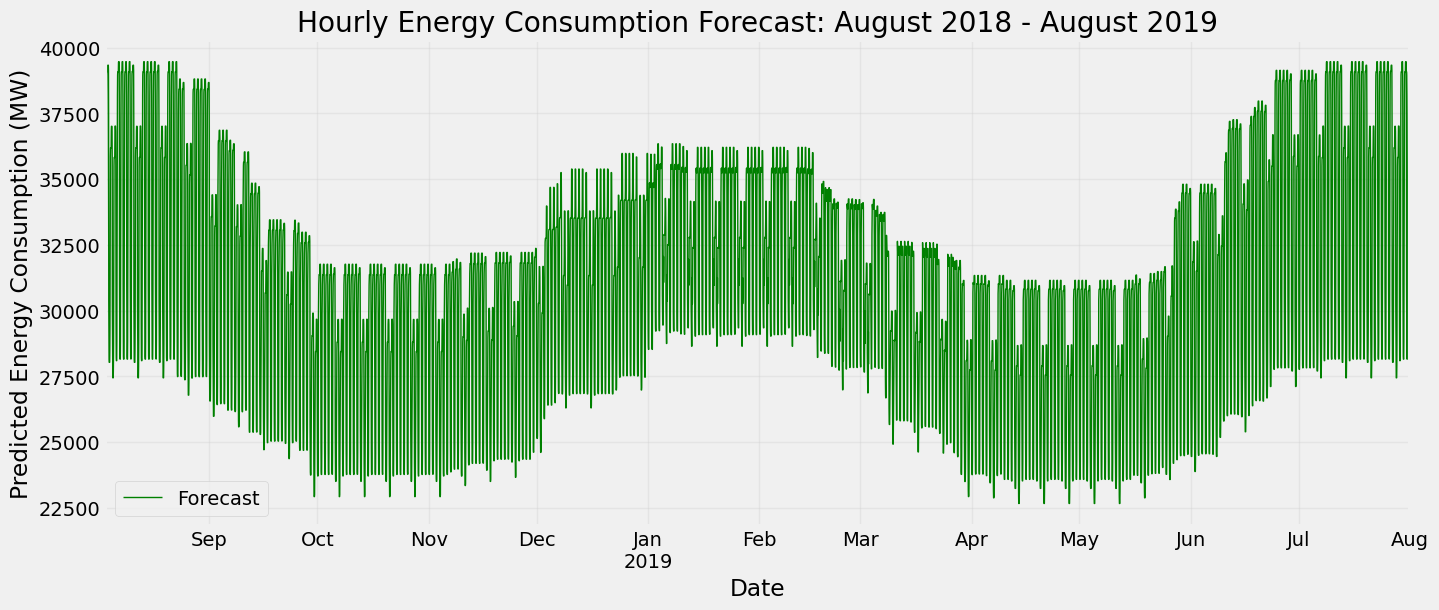

Forecast generated for 8713 hours
Forecast range: 2018-08-03 00:00:00 to 2019-08-01 00:00:00


In [23]:
print("Predicting future values using time-based features only: ")
future_w_features['pred'] = reg_future.predict(future_w_features[FEATURES_NO_LAGS])

# Plot future predictions
plt.figure(figsize=(15, 6))
future_w_features['pred'].plot(color='green', linewidth=1, label='Forecast')
plt.title('Hourly Energy Consumption Forecast: August 2018 - August 2019')
plt.xlabel('Date')
plt.ylabel('Predicted Energy Consumption (MW)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"Forecast generated for {len(future_w_features)} hours")
print(f"Forecast range: {future_w_features.index.min()} to {future_w_features.index.max()}")

# **Bonus: Saving Model For later**

In [24]:
# Save model
reg_future.save_model('future_model.json')
print("Future model saved as 'future_model.json'")

Future model saved as 'future_model.json'


In [25]:
!ls -lh

total 2.1M
-rw-r--r-- 1 root root 554K Feb 25 16:33 future_model.json
---------- 1 root root 1.5M Feb 25 16:33 __notebook__.ipynb


# THE END